In [1]:
from posixpath import pardir
# from keras.applications.vgg16 import VGG16
# from keras.models import Model
# from keras.applications.vgg16 import preprocess_input
# from keras.preprocessing.image import load_img, img_to_array
from numpy import expand_dims
from matplotlib import pyplot
import os
import numpy as np
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE


In [2]:
# Building dataset with a data builder class

# Flag to control rebuilds
REBUILD_DATA = False

PARENT_DIR = os.path.abspath(os.path.dirname(__file__))
DATASET_DIR = os.path.join(PARENT_DIR, 'data/archive/SkinDatasets/datasets')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test')

print (PARENT_DIR)
print (DATASET_DIR)


/Users/stalkr/Development/cnn_sample
/Users/stalkr/Development/cnn_sample/data/archive/SkinDatasets/datasets


In [3]:
# Setting dataset parameters
# data_count = {'wrinkled': 0, 'no_wrinkles': 0}
# labels = {'wrinkled': 0, 'no_wrinkles': 1}
img_size = (160, 160)
batch_size = 32
test_percentage = 0.15


In [4]:
# Import missing package

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [5]:
# Pre processing and building data

training_dataset = image_dataset_from_directory(TRAIN_DIR,
                                                shuffle=True,
                                                batch_size=batch_size,
                                                image_size=img_size)


Found 640 files belonging to 2 classes.


In [6]:
# Testing dataset

testing_dataset = image_dataset_from_directory(TEST_DIR,
                                                shuffle=True,
                                                batch_size=batch_size,
                                                image_size=img_size)

Found 116 files belonging to 2 classes.


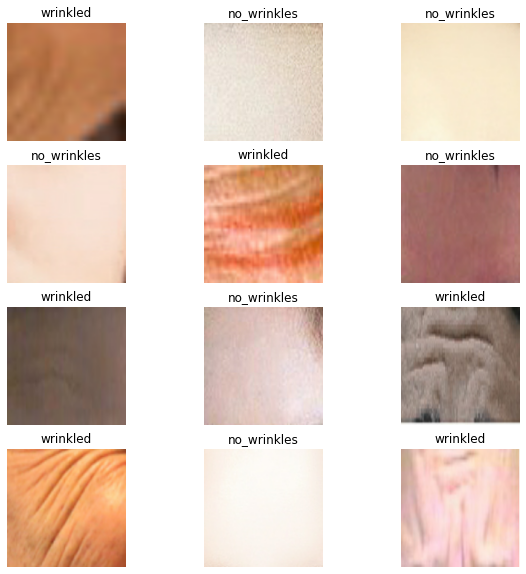

In [7]:
# Visualize the first 12 images from the training dataset

class_labels = training_dataset.class_names

pyplot.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
    for i in range(12):
        ax = pyplot.subplot(4, 3, i+1)
        pyplot.imshow(images[i].numpy().astype("uint8"))
        pyplot.title(class_labels[labels[i]])
        pyplot.axis("off")

pyplot.show()

In [8]:
# Preparing validation dataset
VALIDATION_DIR = os.path.join(DATASET_DIR, 'validation')

validation_dataset = image_dataset_from_directory(VALIDATION_DIR,
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    image_size=img_size)

Found 20 files belonging to 2 classes.


In [9]:

print ("No of validation batches: %d" % tf.data.experimental.cardinality(validation_dataset))
print ("No of testing batches: %d" % tf.data.experimental.cardinality(testing_dataset))
print ("No of training batches: %d" % tf.data.experimental.cardinality(training_dataset))

No of validation batches: 1
No of testing batches: 4
No of training batches: 20


In [10]:
# Tuning for performancs
# From the tf documentation

AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.prefetch(buffer_size=AUTOTUNE)
# testing_dataset = testing_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


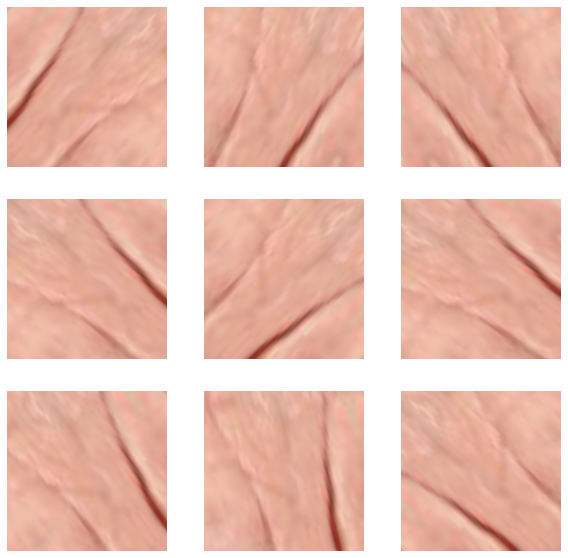

In [16]:
# Testing an augmentation layer

img_augment = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

# Test on a random image
pyplot.figure(figsize=(10, 10))
for images,labels in training_dataset.take(1):
    for i in range(12):
        if class_labels[labels[i]] == 'wrinkled':
            test_image = images[i]
            for j in range(9):
                ax = pyplot.subplot(3, 3, j+1)
                augmented_img = img_augment(tf.expand_dims(test_image, axis=0))
                pyplot.imshow(augmented_img[0] / 255)
                pyplot.axis('off')
            break

pyplot.show()

In [22]:
# Testing a resize and rescale layer

img_rsc = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
])

# pick a random input
img, lbl = next(iter(training_dataset))
img = img_rsc(img)
print ("Pixel values: Min: %d   Max: %d" % (img.numpy().min(), img.numpy().max()))

Pixel values: Min: -1   Max: 1


In [23]:
# Pulling the pretrained model without the top layer
# Importing the MobileNet V2 model developed at Google

image_shape = img_size + (3, )
base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                                include_top=False,
                                                weights='imagenet')

9420800/9406464 [==============================] - 1s 0us/step


In [24]:
# Test output dimensions with an image

img_features = base_model(img)
print ("Feature shape: ", img_features.shape)

Feature shape:  (32, 5, 5, 1280)


In [27]:
# Building the new model

# Pause learning for the base model
base_model.trainable = False

# Average the feature extraction layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# The Dense prediction layer
prediction_layer = tf.keras.layers.Dense(1)

# Build the model
inputs = tf.keras.layers.Input(shape=(160, 160, 3))
x = img_augment(inputs)
x = img_rsc(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [28]:
# Compile the model

learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [33]:
# Testing the model (without training)

loss0, accuracy0 = model.evaluate(validation_dataset)

print ("Initial loss: %0.2f" % loss0)
print ("Initial accuracy: %.4f" % accuracy0)

1/1 [==============================] - 1s 868ms/step - loss: 0.9448 - accuracy: 0.5000
Initial loss: 0.94
Initial accuracy: 0.5000


In [34]:
# Train the model

epochs = 15

history = model.fit(training_dataset,
                    epochs=epochs,
                    validation_data=testing_dataset)

Epoch 1/15
20/20 [==============================] - 28s 983ms/step - loss: 0.9831 - accuracy: 0.4719 - val_loss: 0.8330 - val_accuracy: 0.5172
Epoch 2/15
20/20 [==============================] - 20s 995ms/step - loss: 0.8311 - accuracy: 0.5078 - val_loss: 0.7349 - val_accuracy: 0.5517
Epoch 3/15
20/20 [==============================] - 19s 956ms/step - loss: 0.7699 - accuracy: 0.5281 - val_loss: 0.6554 - val_accuracy: 0.5948
Epoch 4/15
20/20 [==============================] - 20s 978ms/step - loss: 0.6809 - accuracy: 0.6031 - val_loss: 0.5951 - val_accuracy: 0.6207
Epoch 5/15
20/20 [==============================] - 20s 969ms/step - loss: 0.6331 - accuracy: 0.6281 - val_loss: 0.5458 - val_accuracy: 0.6638
Epoch 6/15
20/20 [==============================] - 19s 969ms/step - loss: 0.5614 - accuracy: 0.6906 - val_loss: 0.5025 - val_accuracy: 0.6810
Epoch 7/15
20/20 [==============================] - 20s 990ms/step - loss: 0.5714 - accuracy: 0.7016 - val_loss: 0.4662 - val_accuracy: 0.7155

In [35]:
# Testing again (after training)

loss, accuracy = model.evaluate(validation_dataset)

print ("Trained model loss: %0.2f" % loss)
print ("Trained model accuracy: %.4f" % accuracy)

1/1 [==============================] - 1s 1s/step - loss: 0.3897 - accuracy: 0.7500
Trained model loss: 0.39
Trained model accuracy: 0.7500


In [36]:
# Save the model

model.save('saved_model/wrinkle_detection')

INFO:tensorflow:Assets written to: saved_model/wrinkle_detection/assets
/Users/stalkr/miniconda3/envs/flow-env/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
